In [1]:
import tarfile
import matplotlib.pyplot as plt
from pathlib import Path
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.selection import Selection
from dysh.spectra.core import average
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation

In [2]:
path_to_raw_vegas = f"/home/sdfits/AGBT24B_251_02/AGBT24B_251_02.raw.vegas/" 
sdfits = GBTFITSLoad(path_to_raw_vegas, backend="VEGAS")

Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.


In [3]:
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


In [4]:
BC22_scans = [6, 8, 10, 12, 14, 16]

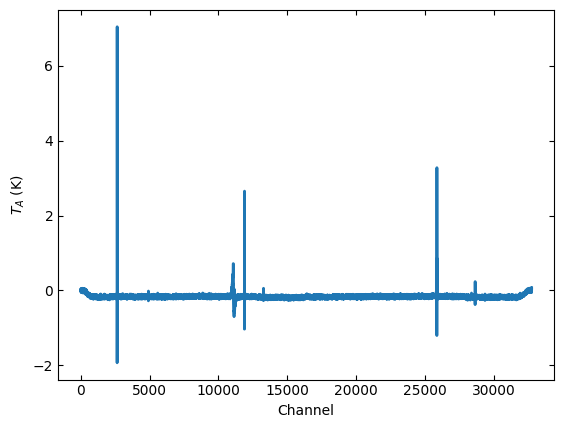

In [5]:
ps_scanblock0 = sdfits.getps(scan=BC22_scans, plnum=0)
ps0 = ps_scanblock0.timeaverage()
ps0.plot(xaxis_unit="chan")

In [6]:
# Initialize lists and arrays to store flag channels, median flux, and MAD flux values
flag_list = []
median_flux_array = np.array([])
MAD_flux_array = np.array([])

# Iterate over each scan in BC22_scans
for scans in BC22_scans:
    # Load the spectra for the current scan
    Single_spectra1 = sdfits.getps(scan=scans, plnum=0)
    Single_spectra = Single_spectra1.timeaverage()
    flux_values = Single_spectra.flux.value  # Access flux values once

    # Calculate median flux and MAD flux for the current spectra
    median_flux = np.median(flux_values)
    median_flux_array = np.append(median_flux_array, median_flux)
    MAD_flux = median_abs_deviation(flux_values)
    MAD_flux_array = np.append(MAD_flux_array, MAD_flux)

    # Create a flag mask for values outside the median ± 5 * MAD range
    flag_mask = np.logical_or(flux_values < median_flux - 5 * MAD_flux,
                              flux_values > median_flux + 5 * MAD_flux)
    flag_chan = np.where(flag_mask)[0]

    # Define bounds and band for flagging
    lower_bound = 800
    upper_bound = 31000
    band = 5
    offsets = np.arange(-band, band + 1)

    # Filter valid flags within the bounds and create new_flag_chan using NumPy operations
    valid_flags = flag_chan[(flag_chan > lower_bound) & (flag_chan < upper_bound)]
    new_flag_chan = np.unique(np.concatenate([valid_flags + offset for offset in offsets] + 
                                             [np.array([i for i in range(0, lower_bound)])] + 
                                             [np.array([i for i in range(upper_bound, len(flux_values))])]))
    new_flag_chan = [int(i) for i in new_flag_chan if i >= 0 and i < len(flux_values)]
    print(f"{scans} number, flags:", new_flag_chan)

    # Flag the channels in the current scan
    sdfits.flag(scan=scans, channel=new_flag_chan, plnum=0)

    # Check if scans+1 is within a valid range before flagging
    if scans + 1 <= max(BC22_scans):
        sdfits.flag(scan=scans + 1, channel=new_flag_chan, plnum=0)

    # Append the new_flag_chan to the flag_list
    flag_list.append(new_flag_chan)

6 number, flags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

In [7]:
sdfits.flags.show()

 ID    TAG    SCAN PLNUM               CHAN               # SELECTED
--- --------- ---- ----- -------------------------------- ----------
  0 3b7d31c84    6     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  1 f2d25b0a9    7     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
 10 d2588da3c   16     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  2 0b699b21b    8     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  3 5c1c0b116    9     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  4 b6e6baf0a   10     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  5 1fe5c0cdb   11     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  6 60a0a40ac   12     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  7 e206faf7f   13     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  8 11aa54c7e   14     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  9 246b0c24b   15     0 [0,1,2,3,4,5,6,...5,32766,32767]        122


INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


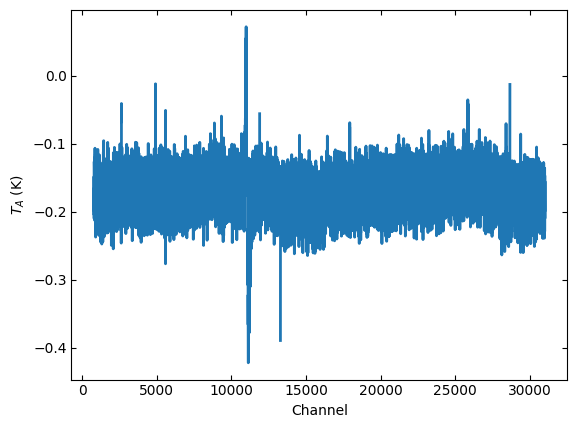

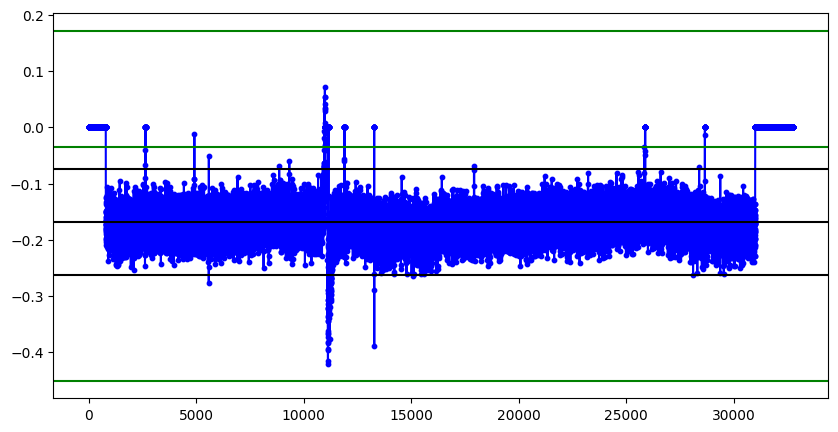

In [28]:
ps_scanblock = sdfits.getps(scan=BC22_scans, plnum=0, apply_flags=True)
ps = ps_scanblock.timeaverage()
ps.plot(xaxis_unit="chan")
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(range(0, len(ps.flux.value)),ps.flux.value, color='b', s=10)
ax.plot(ps.flux.value, color='b')

ax.axhline(np.median(ps.flux.value), color='k')
ax.axhline(np.median(ps.flux.value) - 5*median_abs_deviation(ps.flux.value), color='k')
ax.axhline(np.median(ps.flux.value)+ 5*median_abs_deviation(ps.flux.value), color='k')


ax.axhline(max(median_flux_array), color='g')
ax.axhline(min(median_flux_array - 5*MAD_flux_array), color='g')
ax.axhline(max(median_flux_array+ 5*MAD_flux_array), color='g')

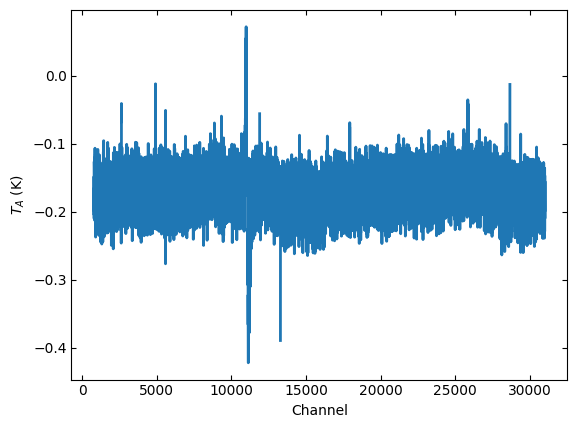

In [ ]:
ps.baseline(model="poly", degree=5, exclude = [()])
ps.plot(xaxis_unit="chan")


In [30]:
smoothing = 5/(ps.velocity[3]-ps.velocity[2]).value

Adjusting decimation factor to be a natural number. Will decimate by 33


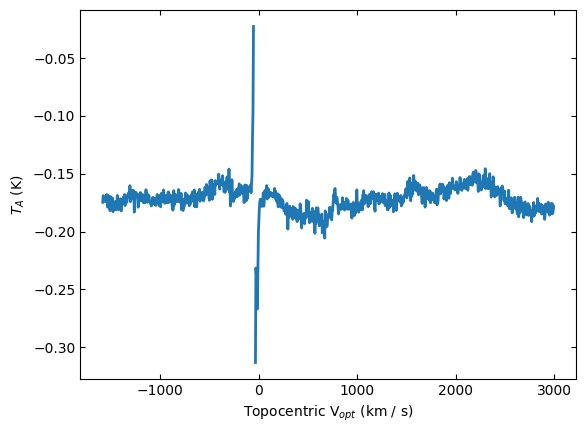

In [31]:
new_ps_smooth = ps.smooth('boxcar', smoothing)
new_ps_smooth.plot(xaxis_unit="km/s")